# Identificación de notas musicales
## Introducción a la programación para ciencia de datos (2019/2020)
### Antonio Manjavacas Lucas

Datos: https://www.kaggle.com/kishanj/music-notes-datasets

En este trabajo se emplearán las diferentes técnicas y herramientas aprendidas en la asignatura para elaborar un **clasificador de notas musicales**. El conjunto de datos de partida es un total de 5000 imágenes (1000 por cada una de las 5 clases) divididas en los siguientes directorios:

* *Eight/* contiene imágenes de **corcheas**
* *Half/* contiene imágenes de **blancas**
* *Quarter/* contiene imágenes de **negras**
* *Sixteenth/* contiene imágenes de **semicorcheas**
* *Whole/* contiene imágenes de **redondas**


In [19]:
import os

import random as rd
rd.seed(42)

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from PIL import Image

from joblib import dump, load

## 1. Carga de datos

Comenzaremos cargando las imágenes de los diferentes directorios...

In [20]:
data_dir = 'data'
img_dirs = os.listdir('data')

images, labels = [], []
for img_dir in img_dirs:
    img_names = os.listdir(os.path.join(data_dir, img_dir))
    for img_name in img_names:
        img_path = os.path.join(data_dir, img_dir, img_name)
        images.append(img_path)
        labels.append(img_dir)

df = pd.DataFrame({'Path':images, 'Class':labels})
df

,Path,Class
0,data/Half/h951.jpg,Half
1,data/Half/h153.jpg,Half
2,data/Half/h868.jpg,Half
3,data/Half/h56.jpg,Half
4,data/Half/h410.jpg,Half
...,...,...
4995,data/Eight/e95.jpg,Eight
4996,data/Eight/e248.jpg,Eight
4997,data/Eight/e958.jpg,Eight
4998,data/Eight/e711.jpg,Eight


Observamos que las imágenes se cargan correctamente y que tienen una dimensión de 64x64:

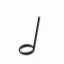

In [21]:
img = Image.open(df.iloc[0,0])
img

In [22]:
img.size

(64, 64)

Con todas las imagénes indexadas procederemos a preprocesarlas.

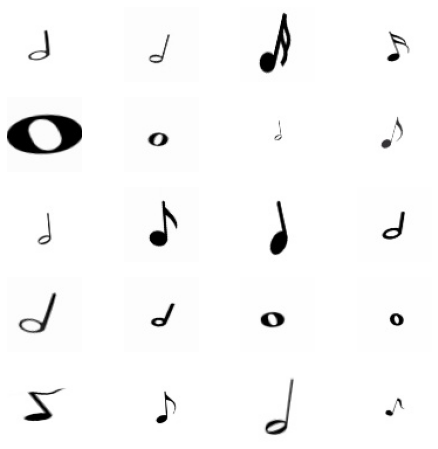

In [23]:
n_images = df.shape[0]

dim = (8,8)
cols = 4
rows = 5

fig=plt.figure(figsize=dim)
for i in range(1, cols * rows + 1):
    img = Image.open(df.iloc[i + rd.randint(0, n_images), 0])
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis('off')

## 2. Preprocesamiento

Vamos a convertir las imágenes en arrays de *numpy* para poder ser utilizadas por nuestro clasificador. 

Para ello, las cargamos como imágenes en escala de grises y después, utilizamos *flatten()* para convertir las matrices en vectores:

In [24]:
flat_images = []
for index, row in df.iterrows():
    img = Image.open(row['Path']).convert('L')
    flat_img = np.ndarray.flatten(np.array(img))  
    flat_images.append(flat_img)
    
notes = pd.DataFrame(flat_images)
notes

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,253,253,253,253,253,253,253,253,253,253,...,253,253,253,253,253,253,253,253,253,253
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,254,254,254,254,254,254,254,254,254,254,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,254,254
4996,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,254,254
4997,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,254,254
4998,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


Tras el preprocesamiento de las imágenes, dividiremos nuestro conjunto de datos en *train* y *test*:

In [25]:
X, y = notes, df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.25, shuffle=True, stratify=y)

Ya está todo preparado para empezar a clasificar.

## 3. Clasificación

Probaremos diferentes modelos de clasificación aplicando ajuste de parámetros mediante *GridSearchCV*.

In [26]:
def fit_and_predict(model, X_train, y_train, X_test=X_train, y_test=y_train, param_grid={}):
    
    model = GridSearchCV(model, param_grid)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    confusion_matrix = pd.crosstab(y_test, y_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')
    plt.show()
    
    return (accuracy_score(y_test, y_pred), model)

### 3.1. Clasificación: *SGDClassifier*

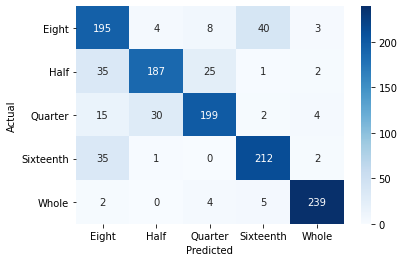

0.8256

In [27]:
sgd_clf = SGDClassifier()

param_grid = {'loss': ['hinge', 'log'], 
              'penalty': ['l1', 'l2'], 
              'alpha': [0.001]}

acc_sgd, sgd_clf = fit_and_predict(sgd_clf, X_train, y_train, X_test, y_test, param_grid)
acc_sgd

### 3.2. Clasificación: *SVC*

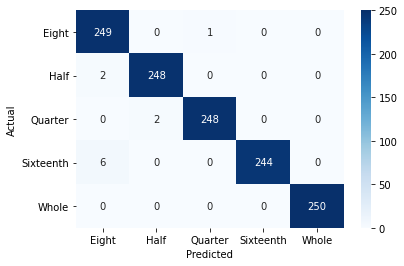

0.9912

In [28]:
svc_clf = SVC()

param_grid = {'C': [1, 10], 
              'gamma': ['scale', 'auto']}

acc_svc, svc_clf = fit_and_predict(svc_clf, X_train, y_train, X_test, y_test, param_grid)
acc_svc

### 3.3. Clasificación: *DecisionTreeClassifier*

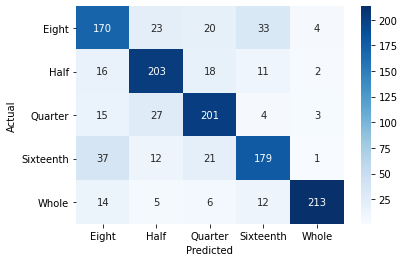

0.7728

In [29]:
tree_clf = DecisionTreeClassifier()

param_grid = {'min_samples_split': [2, 3],
              'min_samples_leaf': [2, 3],
              'max_depth': [7, 9]}

acc_tree, tree_clf = fit_and_predict(tree_clf, X_train, y_train, X_test, y_test, param_grid)
acc_tree

### 3.4. Clasificación: *RandomForest*

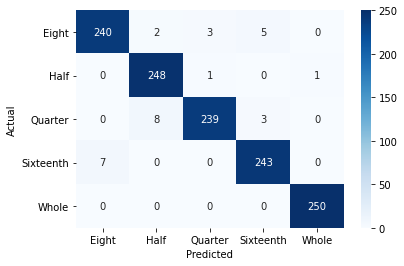

0.976

In [30]:
rf_clf = RandomForestClassifier(n_estimators=120)

param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [None, 7, 9]}

acc_rf, rf_clf = fit_and_predict(rf_clf, X_train, y_train, X_test, y_test, param_grid)
acc_rf

### 3.5. Clasificación: *MLPClassifier*

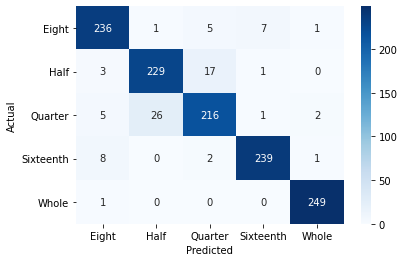

0.9352

In [31]:
nn_clf = MLPClassifier(hidden_layer_sizes=(64,128,64))

param_grid = {'activation': ['tanh', 'relu']}

# escalamos previamente los valores de X_train y X_test
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

acc_nn, nn_clf = fit_and_predict(nn_clf, X_train_scaled, y_train, X_test_scaled, y_test, param_grid)
acc_nn

## 4. Resultados

Compararemos todos los modelos empleados basándonos en el valor de *accuracy*:

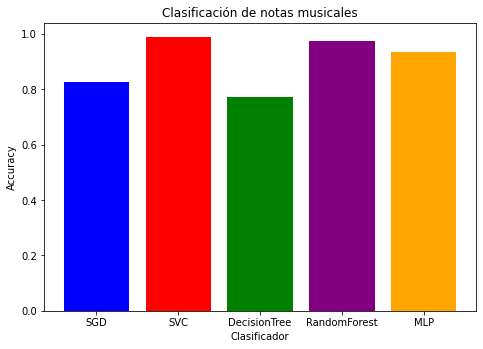

In [32]:
models = ['SGD', 'SVC', 'DecisionTree', 'RandomForest', 'MLP']
accuracies = [acc_sgd, acc_svc, acc_tree, acc_rf, acc_nn]

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.bar(models, accuracies, 
       color=['blue', 'red', 'green', 'purple', 'orange'])

plt.title('Clasificación de notas musicales')
plt.xlabel('Clasificador')
plt.ylabel('Accuracy')

plt.show()

Estas son algunas de las predicciones del mejor modelo:

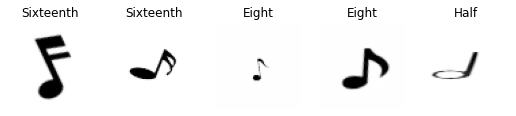

In [33]:
n_images = 5
dim = (9,9)

subset = X_test.iloc[0:n_images]
pred_labels = svc_clf.predict(subset)

images = []
for index, row in subset.iterrows():
    arr = row.to_numpy().reshape(64,64)
    img = Image.fromarray(arr.astype(np.uint8)) 
    images.append(img)
    
fig = plt.figure(figsize=dim)
for i in range(n_images):
    ax = fig.add_subplot(1, n_images, i+1)
    ax.title.set_text(pred_labels[i])
    plt.imshow(images[i], cmap='Greys_r')
    plt.axis('off')

# semicorchea, semicorchea, corchea, corchea, blanca

## 5. Guardar modelo

Finalmente, podemos guardar cualquiera de los modelos obtenidos de forma persistente::

In [34]:
dump(svc_clf, 'music_notes_svc.joblib') 

['music_notes_svc.joblib']